<a href="https://colab.research.google.com/github/kastei/colab/blob/main/local_HW_simpsons_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Домашнее задание по Симпсонам


## Общие настройки


In [1]:
# рабочий каталог на win, для локального запуска в Colab
work_dir = 'D:\\_work\\courses\\stepik\\ML\\data\\'
data_dir = 'D:\\_work\\courses\\stepik\\ML\\data\\journey-springfield\\'

In [ ]:
# ссылки на сохраненные параметры моделей и историю для воспроизведения
#param alexnet:
https://drive.google.com/file/d/1Rt6mkFXeNpzWdx6fS9DtPbsJmkq0G12d/view?usp=sharing
#history alexnet:
https://drive.google.com/file/d/1pCZgm7qgCDXf0n3vAUAFEPCCo-aOkJS1/view?usp=sharing

#param simple cnn:
https://drive.google.com/file/d/1PUey6ih9S2GSKXxk1ZtNUx3yOFVqG9Sd/view?usp=sharing
#history simple cnn:
https://drive.google.com/file/d/14wgf7NpEAYH5MI1ReAe8dO2_0c6fKCn1/view?usp=sharing


### Импорты

In [ ]:
# запуск локального сервера jupyter для работы в Colab из Анаконды ( тут запускать не надо )
jupyter notebook --NotebookApp.allow_origin="https://colab.research.google.com" --no-browser

In [2]:
import os

import torch
import numpy as np
import pandas as pd
 
train_on_gpu = torch.cuda.is_available()
 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import pickle
import numpy as np
import pandas as pd
from skimage import io
 
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from torchvision import transforms
from torchvision import models

from multiprocessing.pool import ThreadPool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


from matplotlib import colors, pyplot as plt
%matplotlib inline
 
# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
# папки для теста и обучения переименованы так:
TRAIN_DIR = Path(os.path.join(data_dir, 'train', 'dataset'))
TEST_DIR = Path(os.path.join(data_dir, 'test', 'dataset'))
 
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

### Класс SimpsonsDataset


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

*   Добавлен флаг augmentation, который включает случайные трансформации картинок
*   Добавлен флаг min_count, который повторяет картинки малочисленных классов до указанного числа
*   Изменно сохранение label_encoder в рабочий каталог



In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, augmentation=False, min_count=0):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        
        # повторим файлы в малочисленных классах 
        if min_count > 0:
            res_file = self.files
            unique_labels = np.unique([path.parent.name for path in self.files])
            for label in unique_labels:
                label_files = [path for path in val_files if path.parent.name == label]
                if min_count > len(label_files):
                  files_to_add = np.repeat(label_files, 1+int(min_count/len(label_files)))
                  res_file = np.concatenate(
                        [res_file,
                        files_to_add[1:min_count]])

            self.files = sorted(res_file)            

        # режим работы
        self.mode = mode
        # режим аугментации
        self.augmentation = augmentation

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
 
        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()
 
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
 
            with open(os.path.join(work_dir, 'label_encoder.pkl'), 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.augmentation == True:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomGrayscale(),
                transforms.RandomRotation(degrees=15),
                #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])    
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

### Разделение на тренировочные и тестовые данные

In [9]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.15, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

### Просмотр картинок датасета
Давайте посмотрим на наших героев внутри датасета.

In [775]:
# количество картинок по классам
tab_files = pd.DataFrame(
      {'labels' : [path.parent.name for path in train_val_files], 
       'count'  : [1 for path in train_val_files]}).groupby('labels', as_index=False).sum()
tab_files.sort_values('count', inplace=True)

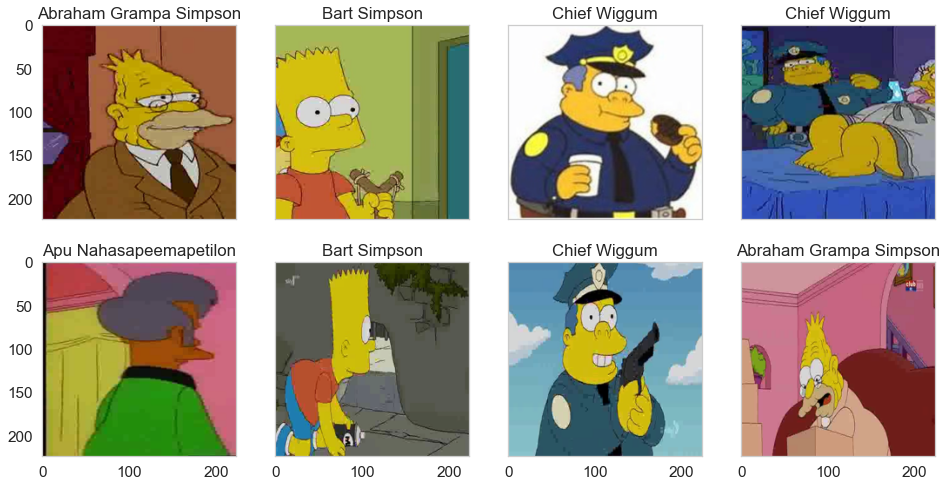

In [776]:
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(16, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), \
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Построение нейросетей

### Simple CNN
*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

In [13]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
 
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [14]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

### AlexNet

In [41]:
alexnet = models.alexnet(pretrained=True).to(DEVICE)

# замораживаем параметры (веса)
for i, param in enumerate(alexnet.parameters()):
    if i in []:
        param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
n_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
n_classes = len(np.unique(train_val_labels))
alexnet.classifier = nn.Linear(n_features, n_classes).to(DEVICE)

In [31]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))
print(alexnet)

we will classify :42
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)


### Методы fit, eval, train, predict

In [38]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
 
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
 
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
 
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [36]:
# поменяем на AdamW
# добавим scheduler
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
 
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
 
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        optimazer = torch.optim.AdamW(model.parameters(), lr=1e-4, \
                                      betas=(0.9, 0.999), weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimazer, \
                                                           gamma=0.9)
 
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimazer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, \
                                           v_acc=val_acc))
            scheduler.step()
        
    return history

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Обучение сети

### Разделение на тренировочные и тестовые данные

In [32]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.15, \
                                          stratify=train_val_labels)

In [33]:
val_dataset = SimpsonsDataset(val_files, mode='val')    
train_dataset = SimpsonsDataset(train_files, mode='train', \
                                augmentation=False, \
                                min_count=500)

### Обучение

In [34]:
# чтобы обнулить лог
history = []

In [59]:
# дописываем лог
#history += train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=128)
history += train(train_dataset, val_dataset, model=alexnet, epochs=5, batch_size=128)

epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

loss 0.01273186552003127


epoch:  20%|███████████████▏                                                            | 1/5 [03:23<13:33, 203.50s/it]


Epoch 001 train_loss: 0.0127     val_loss 0.0436 train_acc 0.9967 val_acc 0.9913
loss 0.008943556200186215


epoch:  40%|██████████████████████████████▍                                             | 2/5 [06:46<10:09, 203.30s/it]


Epoch 002 train_loss: 0.0089     val_loss 0.0567 train_acc 0.9977 val_acc 0.9872
loss 0.0044389412834593385


epoch:  60%|█████████████████████████████████████████████▌                              | 3/5 [10:11<06:47, 203.73s/it]


Epoch 003 train_loss: 0.0044     val_loss 0.0394 train_acc 0.9990 val_acc 0.9922
loss 0.0018185206226535142


epoch:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [13:35<03:24, 204.02s/it]


Epoch 004 train_loss: 0.0018     val_loss 0.0371 train_acc 0.9998 val_acc 0.9925
loss 0.000495452337334342


epoch: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [16:50<00:00, 202.05s/it]


Epoch 005 train_loss: 0.0005     val_loss 0.0398 train_acc 0.9999 val_acc 0.9916


## Сохранение и восстановление параметров сети

In [44]:
# сохраним параметры
torch.save(simple_cnn.state_dict(), os.path.join(work_dir, 'alexnet_balans_final.pth'))
torch.save(history, os.path.join(work_dir, 'alexnet_balans_final.pt'))

In [15]:
# восстановим
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

simple_cnn.load_state_dict(torch.load(os.path.join(work_dir, 'simple_cnn_balans_final.pth')))
simple_cnn.eval()
history = torch.load(os.path.join(work_dir, 'history_cnn_balans_final.pt'))

## Построим кривые обучения

In [60]:
loss, acc, val_loss, val_acc = zip(*history)

In [61]:
# баг с тензором, оставшимся на gpu
val_acc = [x.cpu() for x in val_acc] 

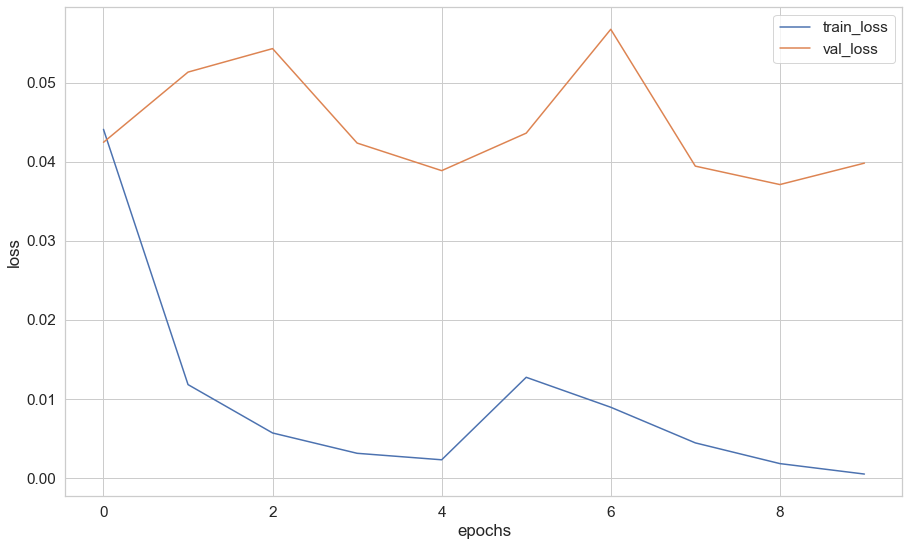

In [62]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

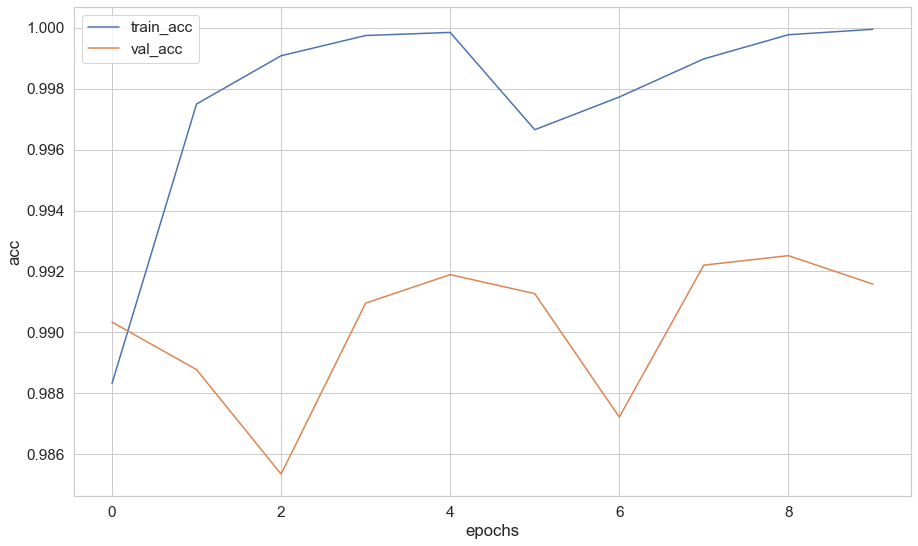

In [63]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

## Анализ Simple CNN

Поиски и оптимизация:

> во первых в совсем малочисленые классы (disco_stu, lionel_hutz, miss_hoover, troy_mcclure) добавил сообранные вручную картинки.

> epochs=45, batch_size=512, augmentation=False: train_acc 0.7293 val_acc 0.7849, дальнейшее обучение с такими параметрами не дает прироста точности

> epochs=10, batch_size=64, augmentation=True: train_acc 0.7758 val_acc 0.8333, kaggle 0.84803

> epochs=10, batch_size=128, augmentation=True: train_acc 0.8033 val_acc 0.8937, f1 0.89163, kaggle 0.88841

после балансировки классов дублированием малочисленных классов до 200:

> epochs=50, batch_size=128, augmentation=True: train_acc 0.9612 val_acc 0.9761, f1 0.97486, kaggle 0.95217

>\+ еще 10 эпох без трансформаций

> epochs=10, batch_size=128, augmentation=False: train_acc 0.9991 val_acc 0.9965, f1 0.99502, kaggle 0.98405

Итоговая конфигурация SimpleCNN на сбалансированном датасете (копирование до 500) учится за 20 эпох с угментацией и 10 эпох без трансформаций (трансформации сильно замедляют обучение) до приемлемых показателей:

train_acc 0.9998, val_acc 0.9882, f1 0.99906, kaggle 0.99574


## Анализ AlexNet

за 10 эпох получен такой же результат, но значительно проще и быстрее:

train_acc 0.9999, val_acc 0.9916, f1 0.99813, kaggle 0.99256


## Предсказания

In [49]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [50]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [51]:
# рандомная пачка из 20 картинок на проверку
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [65]:
# все валидационные данные
idxs = range(len(val_dataset))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [66]:
label_encoder = pickle.load(open(os.path.join(work_dir, 'label_encoder.pkl'), 'rb'))

In [67]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [70]:
f1_score(actual_labels, y_pred, average='micro')

0.9981296758104738

### Анализ предсказаний
Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете использовать это, чтобы отлаживать правильность вывода.

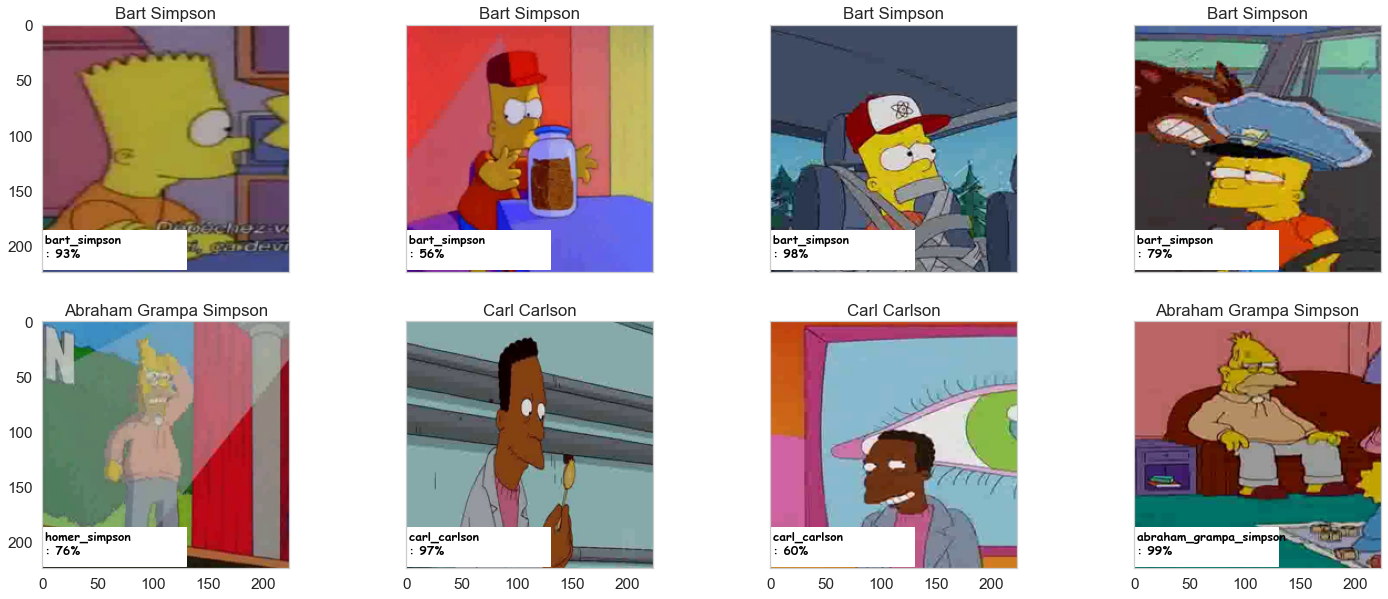

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    
    random_characters = int(np.random.uniform(0,1000))
    
    """
    # для просмотра ошибок, stat_data вычисляется ниже
    err_data = stat_data[stat_data['true_label'] != stat_data['pred_label']]
    rand_ind = int(np.random.uniform(0, len(err_data)))
    random_characters = err_data.iloc[[rand_ind]].index[0]

    """

    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 186),130,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label
    predicted_text = "{} \n: {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(2, 190, predicted_text, horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=12, color='black', fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [ ]:
stat_data = pd.DataFrame(
    [
     (
      np.argmax(probs).flatten().tolist()[0],
      np.max(probs),
      np.argwhere(probs>0.5*np.max(probs)).flatten(),
      probs[np.argwhere(probs>0.5*np.max(probs)).flatten().tolist()].flatten(),
      label_encoder.classes_[np.argwhere(probs>0.5*np.max(probs)).flatten()],
      label_encoder.classes_[np.argmax(probs).flatten().tolist()[0]],
      label_encoder.classes_[val_dataset[i][1]]
  ) for (i, probs) in enumerate(probs_ims)], columns=['ind', 'prob', 'indx', 'probs', 'labels', 'pred_label', 'true_label'])

In [ ]:
stat_data[stat_data['true_label'] != stat_data['pred_label']]

,ind,prob,indx,probs,labels,pred_label,true_label
26,27,0.178459,"[0, 17, 27, 32]","[0.14664972, 0.17478798, 0.17845936, 0.14782098]","[abraham_grampa_simpson, krusty_the_clown, moe...",moe_szyslak,abraham_grampa_simpson
30,20,0.745291,[20],[0.74529105],[lisa_simpson],lisa_simpson,abraham_grampa_simpson
49,37,0.534549,"[2, 37]","[0.26869008, 0.53454876]","[apu_nahasapeemapetilon, sideshow_bob]",sideshow_bob,abraham_grampa_simpson
54,15,0.613239,[15],[0.6132388],[homer_simpson],homer_simpson,abraham_grampa_simpson
55,15,0.801903,[15],[0.80190325],[homer_simpson],homer_simpson,abraham_grampa_simpson
...,...,...,...,...,...,...,...
6039,6,0.323232,"[6, 37]","[0.32323185, 0.19624367]","[charles_montgomery_burns, sideshow_bob]",charles_montgomery_burns,waylon_smithers
6040,6,0.323232,"[6, 37]","[0.32323185, 0.19624367]","[charles_montgomery_burns, sideshow_bob]",charles_montgomery_burns,waylon_smithers
6041,6,0.323232,"[6, 37]","[0.32323185, 0.19624367]","[charles_montgomery_burns, sideshow_bob]",charles_montgomery_burns,waylon_smithers
6042,6,0.323232,"[6, 37]","[0.32323185, 0.19624367]","[charles_montgomery_burns, sideshow_bob]",charles_montgomery_burns,waylon_smithers


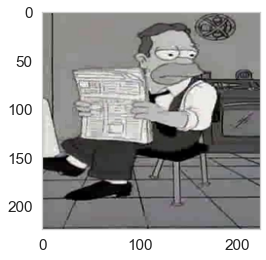

In [ ]:
im_val, label = val_dataset[26]
imshow(im_val.data.cpu())

## Submit на Kaggle

In [64]:
#model = simple_cnn
model = alexnet

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [57]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [69]:
my_submit.to_csv(os.path.join(work_dir, 'alexnet_local_balans.csv'), index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
